In [1]:
##control.do
#!pip install linearmodels
#!pip install econtools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from linearmodels import PanelOLS
import statsmodels.api as sm
import econtools as econ
import econtools.metrics as mt

df = pd.read_stata('data/Authority.dta')
print(df.shape)
#list(df.columns)

#construct work category dummy
df['OG03_dummy'] = 0
df.loc[(df['work_category']=='OG03')&(df['work_category']!=''),'OG03_dummy'] = 1

df['OG01_dummy'] = 0
df.loc[(df['work_category']=='OG01')&(df['work_category']!=''),'OG01_dummy'] = 1

df['OG_rest_dummy'] = 0
df.loc[(df['OG01_dummy']!=1)&(df['OG03_dummy']!=1)&(df['work_category']!=''),'OG_rest_dummy'] = 1

df['OG_dummy'] = 0
df.loc[df['work_category'].str[0:2] == 'OG','OG_dummy'] = 1

df['OS_dummy'] = 0
df.loc[df['work_category'].str[0:2] == 'OS','OS_dummy'] = 1

#treated vs controls
df['trend'] = df['year'] - 1999

df['trend_treat'] = df['trend']
df.loc[(df['authority_code']!=3090272)&(df['authority_code']!=3070001),'trend_treat'] = 0
#15225 real change made / no zeros in df['trend']
#print(df['trend_treat'].value_counts()) chekced

df['trend_control'] = df['trend']
df.loc[(df['authority_code']==3090272)|(df['authority_code']==3070001),'trend_control'] = 0
#902 real change made
#print(df['trend_control'].value_counts()) checked

#PA specifics
df = df.sort_values(by='authority_code',ascending=True)
#auth = econ.group_id(df, cols = 'authority_code')
#print(auth) #dataframe

auth_list = df['authority_code'].values.tolist()
auth_list = list(set(auth_list))
#겹치는 부분 = authority_code야
#id_auth = group_id + 1 if df의 auth code == auth의 code

df['id_auth'] = 0
for i in range(len(df)):
    for j in range(len(auth_list)):
        if df.loc[i,'authority_code'] == auth_list[j]:
            df.loc[i,'id_auth'] = j+1

(16127, 31)


In [2]:
for i in range(len(auth_list)):
    name = 'trend_pa_'+str(i+1)
    df[name] = 0
    for j in range(len(df)):
        if df.loc[j, 'id_auth'] == i+1 :
            df.loc[j, name] = df.loc[j,'trend']
        if df.loc[j, 'authority_code']==3090272 or df.loc[j, 'authority_code']==3070001:
            df.loc[j, name] = 0
#for statement check            
#df.head

In [3]:
work_dum = pd.get_dummies(df['work_category'])
year_dum = pd.get_dummies(df['year'])
work_list = list(work_dum.columns)
year_list = list(year_dum.columns)

df_dum = pd.concat([year_dum, work_dum],axis = 1)
df = pd.concat([df, df_dum],axis = 1)

# table 4 odd columns

In [82]:
#table 4
#(:,[1,3,5,7])/ co& ctrl_exp
outcome = ['discount', 'delay_ratio', 'overrun_ratio', 'days_to_award']
treatment = ['turin_co_sample','turin_pr_sample']
# mutlicollinearity function
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

#iteration for group
for o in outcome:
    for t in treatment:
        df_reg_t = df[(df[t]==1)&(df['ctrl_exp_' + t]==1)&(df['post_experience']>= 5) & (df['pre_experience']>=5) &(df['post_experience'].isnull() == False ) & (df['pre_experience'].isnull()==False)&(df['missing']==0)]
        idx = df_reg_t[df_reg_t[o].isnull()==True].index
        df_reg_o = df_reg_t.drop(idx)
        #vif cal
        #first, make a column list
        reg_col = []
        for i in work_list:
            reg_col.append(i)
        for j in year_list:
            reg_col.append(j)
        exog_var = ['fpsb_auction','reserve_price','municipality','fiscal_efficiency'] #id_auth빼봄
        exog = exog_var + reg_col 


        #check multicollinearity
        X = df_reg_o.loc[:,exog]
        vif = calc_vif(X)
        #print(vif)


        #delete from col list
        for i in range(len(vif)):
            if np.isnan(vif.loc[i, 'VIF']) == True:
                reg_col.remove(vif.loc[i, 'variables'])
            elif vif.loc[i,'VIF'] > 10:
                for j in exog_var:
                    if str(vif.loc[i,'variables']) is j and vif.loc[i,'variables'] is not 'fpsb_auction' and vif.loc[i,'variables'] is not 'id_auth':
                        exog_var.remove(vif.loc[i,'variables'])
                
        exog = exog_var + reg_col
        #exog.remove('id_auth')
        exog.remove(2000)
        exog.remove('OG01')
        exog.remove('municipality')

        #print(exog) #check
        print(mt.reg(df_reg_o, o, exog, fe_name = 'authority_code', cluster = 'auth_anno'))

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dependent variable:	discount
N:			1262
R-squared:		0.6395
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  101
Fixed effects by:	authority_code
  No. of FE:		  15
                   coeff    se      t   p>t  CI_low CI_high
fpsb_auction      12.178 1.329  9.163 0.000   9.541  14.815
reserve_price      0.000 0.000  5.988 0.000   0.000   0.000
fiscal_efficiency -2.611 4.586 -0.569 0.570 -11.709   6.486
OG02               0.223 0.629  0.354 0.724  -1.024   1.470
OG03              -0.560 0.543 -1.032 0.304  -1.638   0.517
OG04              -4.715 3.311 -1.424 0.157 -11.283   1.853
OG06               0.816 0.667  1.223 0.224  -0.508   2.140
OG07               4.494 5.104  0.881 0.381  -5.632  14.620
OG08               0.788 1.600  0.492 0.624  -2.386   3.961
OG10               8.384 0.510 16.450 0.000   7.373   9.396
OG11               5.676 1.066  5.325 0.000   3.561   7.791
OG12               5.928 1.926  3.079 0.003   2.108   9.749
OS01     

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dependent variable:	discount
N:			1355
R-squared:		0.5792
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  120
Fixed effects by:	authority_code
  No. of FE:		  18
                   coeff    se      t   p>t  CI_low CI_high
fpsb_auction       8.705 1.086  8.015 0.000   6.554  10.856
reserve_price      0.000 0.000  8.603 0.000   0.000   0.000
fiscal_efficiency  0.621 3.592  0.173 0.863  -6.491   7.733
OG02              -0.896 0.585 -1.532 0.128  -2.054   0.262
OG03              -1.441 0.404 -3.563 0.001  -2.241  -0.640
OG04              -5.535 3.418 -1.619 0.108 -12.303   1.233
OG06              -0.360 0.701 -0.513 0.609  -1.748   1.029
OG07               1.709 3.357  0.509 0.612  -4.938   8.355
OG08               3.020 1.904  1.586 0.115  -0.751   6.791
OG09               2.112 1.253  1.686 0.094  -0.368   4.593
OG10               7.837 0.481 16.306 0.000   6.885   8.788
OG11               5.187 0.869  5.969 0.000   3.466   6.907
OG12     

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dependent variable:	delay_ratio
N:			1110
R-squared:		0.1223
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  99
Fixed effects by:	authority_code
  No. of FE:		  15
                    coeff     se      t   p>t  CI_low CI_high
fpsb_auction       32.425 12.670  2.559 0.012   7.282  57.569
reserve_price      -0.000  0.000 -2.008 0.047  -0.000  -0.000
fiscal_efficiency  23.435 32.561  0.720 0.473 -41.182  88.051
OG02               -0.809 10.351 -0.078 0.938 -21.351  19.732
OG03                8.113  5.348  1.517 0.132  -2.500  18.726
OG04              -16.416  6.760 -2.429 0.017 -29.830  -3.002
OG06               31.446 11.001  2.858 0.005   9.615  53.277
OG07               46.220 24.340  1.899 0.061  -2.083  94.523
OG08               14.813 14.847  0.998 0.321 -14.651  44.277
OG10               57.716 11.336  5.091 0.000  35.220  80.212
OG11                4.585 12.645  0.363 0.718 -20.508  29.678
OG12               40.831 50.769  0.804 0.4

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dependent variable:	delay_ratio
N:			1206
R-squared:		0.1264
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  117
Fixed effects by:	authority_code
  No. of FE:		  18
                    coeff     se      t   p>t   CI_low CI_high
fpsb_auction       11.203 18.748  0.598 0.551  -25.930  48.336
reserve_price      -0.000  0.000 -2.630 0.010   -0.000  -0.000
fiscal_efficiency  18.482 34.883  0.530 0.597  -50.608  87.571
OG02               -0.586  8.087 -0.072 0.942  -16.603  15.431
OG03               16.581  4.814  3.444 0.001    7.047  26.116
OG04              -14.859  6.888 -2.157 0.033  -28.501  -1.216
OG06               36.683 11.095  3.306 0.001   14.708  58.657
OG07                4.885 18.197  0.268 0.789  -31.156  40.925
OG08               15.325 14.113  1.086 0.280  -12.628  43.277
OG10               58.561 10.657  5.495 0.000   37.453  79.669
OG11                8.157 10.594  0.770 0.443  -12.826  29.140
OG12               78.036 52.7

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dependent variable:	overrun_ratio
N:			1092
R-squared:		0.1559
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  98
Fixed effects by:	authority_code
  No. of FE:		  15
                    coeff    se      t   p>t  CI_low CI_high
fpsb_auction        5.987 1.937  3.091 0.003   2.142   9.832
reserve_price       0.000 0.000  3.849 0.000   0.000   0.000
fiscal_efficiency  -1.614 7.339 -0.220 0.826 -16.180  12.953
OG02               -3.400 1.537 -2.212 0.029  -6.450  -0.350
OG03               -3.545 1.253 -2.830 0.006  -6.032  -1.059
OG04               -7.583 1.414 -5.362 0.000 -10.390  -4.776
OG06               -4.444 1.819 -2.443 0.016  -8.055  -0.834
OG07                6.928 2.420  2.863 0.005   2.125  11.730
OG08               -5.475 2.264 -2.419 0.017  -9.968  -0.983
OG10               -6.143 2.779 -2.211 0.029 -11.658  -0.628
OG11                0.780 2.402  0.325 0.746  -3.987   5.547
OG12               -5.536 4.402 -1.258 0.212 -14.273 

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dependent variable:	overrun_ratio
N:			1167
R-squared:		0.1490
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  117
Fixed effects by:	authority_code
  No. of FE:		  18
                    coeff    se      t   p>t  CI_low CI_high
fpsb_auction        0.294 3.587  0.082 0.935  -6.810   7.398
reserve_price       0.000 0.000  2.735 0.007   0.000   0.000
fiscal_efficiency   3.603 7.556  0.477 0.634 -11.363  18.569
OG02               -2.196 1.427 -1.539 0.127  -5.021   0.630
OG03               -2.286 1.186 -1.927 0.056  -4.634   0.063
OG04               -7.931 1.561 -5.080 0.000 -11.023  -4.839
OG06               -3.142 1.731 -1.816 0.072  -6.570   0.285
OG07               -2.305 7.282 -0.317 0.752 -16.727  12.117
OG08               -0.734 3.679 -0.199 0.842  -8.021   6.554
OG09              -10.675 3.357 -3.180 0.002 -17.323  -4.027
OG10               -5.405 3.014 -1.793 0.076 -11.375   0.565
OG11                1.211 2.340  0.517 0.606  -3.424

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dependent variable:	days_to_award
N:			777
R-squared:		0.5679
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  88
Fixed effects by:	authority_code
  No. of FE:		  15
                    coeff     se      t   p>t   CI_low CI_high
fpsb_auction       30.511 11.212  2.721 0.008    8.225  52.797
reserve_price       0.000  0.000  1.143 0.256   -0.000   0.000
fiscal_efficiency -67.925 41.480 -1.638 0.105 -150.371  14.521
OG02               -1.111  5.960 -0.186 0.853  -12.956  10.735
OG03                6.212  4.361  1.425 0.158   -2.455  14.879
OG06               -4.704  7.841 -0.600 0.550  -20.290  10.881
OG07              -22.845  7.903 -2.891 0.005  -38.553  -7.137
OG08                9.671 13.769  0.702 0.484  -17.695  37.038
OG10              -26.882  9.212 -2.918 0.004  -45.192  -8.572
OG11                7.755 13.307  0.583 0.562  -18.694  34.204
OG12               -0.906  8.774 -0.103 0.918  -18.345  16.534
OS01                1.165 11.2

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dependent variable:	days_to_award
N:			817
R-squared:		0.4097
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  106
Fixed effects by:	authority_code
  No. of FE:		  18
                    coeff     se      t   p>t   CI_low CI_high
fpsb_auction       36.449  8.347  4.367 0.000   19.898  53.000
reserve_price       0.000  0.000  1.231 0.221   -0.000   0.000
fiscal_efficiency -35.186 40.331 -0.872 0.385 -115.155  44.783
OG02              -16.185  6.553 -2.470 0.015  -29.179  -3.191
OG03                0.238  3.378  0.070 0.944   -6.460   6.936
OG06               -2.814  5.935 -0.474 0.636  -14.582   8.954
OG07              -35.487 10.939 -3.244 0.002  -57.177 -13.796
OG08              -17.165  9.104 -1.885 0.062  -35.217   0.887
OG09              -11.939 12.204 -0.978 0.330  -36.138  12.260
OG10              -36.299  9.679 -3.750 0.000  -55.491 -17.107
OG11                8.390  8.615  0.974 0.332   -8.693  25.473
OG12               -7.449 12.

# Table 4 even columns

In [81]:
#talbe4
#first row, even columns final version

outcome = ['discount', 'delay_ratio','overrun_ratio', 'days_to_award']

# mutlicollinearity function
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

#iteration for group
for o in outcome:
    df_reg_co = df[(df['turin_co_sample']==1)&(df['ctrl_exp_turin_co_sample']==1)&(df['post_experience']>= 5) & (df['pre_experience']>=5) &(df['post_experience'].isnull() == False ) & (df['pre_experience'].isnull()==False)&(df['missing']==0)]
    
    #vif cal
    #first, make a column list
    reg_col = ['trend_pa_2','trend_pa_3','trend_pa_5','trend_pa_8','trend_pa_15','trend_pa_19','trend_pa_24','trend_pa_29','trend_pa_1231',
              'trend_pa_1690','trend_pa_1721','trend_pa_1749','trend_pa_1839']
    for i in work_list:
        reg_col.append(i)
    for j in year_list:
        reg_col.append(j)
    exog_var = ['fpsb_auction','reserve_price','municipality','trend','trend_treat']
    exog = exog_var + reg_col 


    #check multicollinearity
    X = df_reg_co.loc[:,exog]
    vif = calc_vif(X)
    print(vif)


    #delete from col list
    for i in range(len(vif)):
        if np.isnan(vif.loc[i, 'VIF']) == True:
            reg_col.remove(vif.loc[i, 'variables'])
        elif vif.loc[i,'VIF'] > 10:
            for j in exog_var:
                if str(vif.loc[i,'variables']) is j and vif.loc[i,'variables'] is not 'fpsb_auction' and vif.loc[i,'variables'] is not 'id_auth':
                    exog_var.remove(vif.loc[i,'variables'])
                
    exog = exog_var + reg_col
    
    exog.remove(2000)
    exog.remove('OG01')
    exog.remove('municipality')


    if o == 'overrun_ratio':
        exog.remove('OS07')
        fe_reg = mt.reg(df_reg_co, o , exog, fe_name = 'authority_code', cluster = 'auth_anno')
        print(fe_reg)
        
    elif o == 'days_to_award':
        exog.remove('OG04')
        exog.remove('OS05')
        exog.remove('OS07')
        exog.remove('OS11')
        exog.remove('OS26')
        fe_reg = mt.reg(df_reg_co, o , exog, fe_name = 'authority_code', cluster = 'auth_anno')
        print(fe_reg)
    else:
        fe_reg = mt.reg(df_reg_co, o , exog, fe_name = 'authority_code', cluster = 'auth_anno')
        print(fe_reg)
        

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


        variables       VIF
0    fpsb_auction  7.409896
1   reserve_price  1.161375
2    municipality  6.868839
3           trend       inf
4     trend_treat  8.729106
..            ...       ...
66           2006       inf
67           2007       NaN
68           2008       NaN
69           2009       NaN
70           2010       NaN

[71 rows x 2 columns]
Dependent variable:	discount
N:			1262
R-squared:		0.6515
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  101
Fixed effects by:	authority_code
  No. of FE:		  15
               coeff    se       t   p>t  CI_low CI_high
fpsb_auction   6.136 1.305   4.703 0.000   3.547   8.724
reserve_price  0.000 0.000   6.106 0.000   0.000   0.000
trend_treat    1.503 0.437   3.440 0.001   0.636   2.370
trend_pa_2    -0.562 1.409  -0.399 0.691  -3.358   2.234
trend_pa_3    -0.020 0.637  -0.032 0.975  -1.284   1.243
trend_pa_5    -1.039 0.301  -3.454 0.001  -1.636  -0.442
trend_pa_8    -0.598 0.572  -1.

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


        variables       VIF
0    fpsb_auction  7.409896
1   reserve_price  1.161375
2    municipality  6.868839
3           trend       inf
4     trend_treat  8.729106
..            ...       ...
66           2006       inf
67           2007       NaN
68           2008       NaN
69           2009       NaN
70           2010       NaN

[71 rows x 2 columns]
Dependent variable:	delay_ratio
N:			1110
R-squared:		0.1352
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  99
Fixed effects by:	authority_code
  No. of FE:		  15
                coeff     se      t   p>t  CI_low CI_high
fpsb_auction    5.323 28.383  0.188 0.852 -51.002  61.649
reserve_price  -0.000  0.000 -2.081 0.040  -0.000  -0.000
trend_treat     1.443  7.200  0.200 0.842 -12.846  15.731
trend_pa_2     -4.176 10.863 -0.384 0.702 -25.733  17.382
trend_pa_3     -6.929  7.228 -0.959 0.340 -21.272   7.415
trend_pa_5     13.963 15.197  0.919 0.360 -16.195  44.121
trend_pa_8    -12.507 

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


        variables       VIF
0    fpsb_auction  7.409896
1   reserve_price  1.161375
2    municipality  6.868839
3           trend       inf
4     trend_treat  8.729106
..            ...       ...
66           2006       inf
67           2007       NaN
68           2008       NaN
69           2009       NaN
70           2010       NaN

[71 rows x 2 columns]
Dependent variable:	overrun_ratio
N:			1092
R-squared:		0.1703
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  98
Fixed effects by:	authority_code
  No. of FE:		  15
                coeff    se      t   p>t  CI_low CI_high
fpsb_auction   -0.821 3.583 -0.229 0.819  -7.932   6.289
reserve_price   0.000 0.000  3.800 0.000   0.000   0.000
trend_treat     1.866 1.326  1.407 0.163  -0.766   4.498
trend_pa_2     -0.924 0.784 -1.179 0.241  -2.480   0.632
trend_pa_3      1.335 1.010  1.322 0.189  -0.669   3.339
trend_pa_5     -0.364 0.982 -0.371 0.712  -2.312   1.584
trend_pa_8     -1.470 0.447

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


        variables       VIF
0    fpsb_auction  7.409896
1   reserve_price  1.161375
2    municipality  6.868839
3           trend       inf
4     trend_treat  8.729106
..            ...       ...
66           2006       inf
67           2007       NaN
68           2008       NaN
69           2009       NaN
70           2010       NaN

[71 rows x 2 columns]
Dependent variable:	days_to_award
N:			777
R-squared:		0.5970
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  88
Fixed effects by:	authority_code
  No. of FE:		  15
                coeff     se      t   p>t  CI_low CI_high
fpsb_auction   25.438 22.608  1.125 0.264 -19.498  70.374
reserve_price   0.000  0.000  0.725 0.470  -0.000   0.000
trend_treat     0.155  6.085  0.025 0.980 -11.939  12.248
trend_pa_2     11.834  3.046  3.885 0.000   5.780  17.887
trend_pa_3      8.205  6.241  1.315 0.192  -4.198  20.609
trend_pa_5     -0.355  4.984 -0.071 0.943 -10.261   9.550
trend_pa_8    -11.146

In [4]:
#table 4 discount
#(:,2)/ co/pr& ctrl_exp #trend_pa 들어가서 무지하게 큼

treatment = ['turin_co_sample','turin_pr_sample']
# mutlicollinearity function
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

#iteration for group
for t in treatment:
    df_reg_co = df[(df[t]==1)&(df['ctrl_exp_' + t]==1)&(df['post_experience']>= 5) & (df['pre_experience']>=5) &(df['post_experience'].isnull() == False ) & (df['pre_experience'].isnull()==False)&(df['missing']==0)]
    
    #vif cal
    #first, make a column list
    reg_col = ['trend_pa_2','trend_pa_3','trend_pa_5','trend_pa_8','trend_pa_15','trend_pa_19','trend_pa_24','trend_pa_29','trend_pa_33','trend_pa_585','trend_pa_1231',
              'trend_pa_1480', 'trend_pa_1690','trend_pa_1721','trend_pa_1749','trend_pa_1839']
    for i in work_list:
        reg_col.append(i)
    for j in year_list:
        reg_col.append(j)
    exog_var = ['fpsb_auction','reserve_price','municipality','trend','trend_treat'] #id_auth빼봄
    exog = exog_var + reg_col 


    #check multicollinearity
    X = df_reg_co.loc[:,exog]
    vif = calc_vif(X)
    #print(vif)


    #delete from col list
    for i in range(len(vif)):
        if np.isnan(vif.loc[i, 'VIF']) == True:
            reg_col.remove(vif.loc[i, 'variables'])
        elif vif.loc[i,'VIF'] > 10:
            for j in exog_var:
                if str(vif.loc[i,'variables']) is j and vif.loc[i,'variables'] is not 'fpsb_auction' and vif.loc[i,'variables'] is not 'id_auth':
                    exog_var.remove(vif.loc[i,'variables'])
                
    exog = exog_var + reg_col
    #exog.remove('id_auth')
    exog.remove(2000)
    exog.remove('OG01')
    exog.remove('municipality')

    #print(exog) #check
    fe_reg = mt.reg(df_reg_co, 'discount', exog, fe_name = 'authority_code', cluster = 'auth_anno')
    print(fe_reg)

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dependent variable:	discount
N:			1262
R-squared:		0.6515
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  101
Fixed effects by:	authority_code
  No. of FE:		  15
               coeff    se       t   p>t  CI_low CI_high
fpsb_auction   6.136 1.305   4.703 0.000   3.547   8.724
reserve_price  0.000 0.000   6.106 0.000   0.000   0.000
trend_treat    1.503 0.437   3.440 0.001   0.636   2.370
trend_pa_2    -0.562 1.409  -0.399 0.691  -3.358   2.234
trend_pa_3    -0.020 0.637  -0.032 0.975  -1.284   1.243
trend_pa_5    -1.039 0.301  -3.454 0.001  -1.636  -0.442
trend_pa_8    -0.598 0.572  -1.045 0.299  -1.734   0.538
trend_pa_15   -0.722 0.304  -2.377 0.019  -1.324  -0.119
trend_pa_19    0.672 0.440   1.529 0.129  -0.200   1.544
trend_pa_24   -0.218 0.231  -0.942 0.348  -0.677   0.241
trend_pa_29   -0.293 0.728  -0.402 0.689  -1.737   1.151
trend_pa_1231  0.439 0.340   1.292 0.199  -0.235   1.113
trend_pa_1690  0.650 0.326   1.997 0.049   0.004

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dependent variable:	discount
N:			1355
R-squared:		0.5915
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  120
Fixed effects by:	authority_code
  No. of FE:		  18
               coeff    se       t   p>t  CI_low CI_high
fpsb_auction   7.564 0.884   8.552 0.000   5.813   9.315
reserve_price  0.000 0.000   8.537 0.000   0.000   0.000
trend_pa_2    -0.942 1.455  -0.648 0.518  -3.824   1.939
trend_pa_3     0.168 0.651   0.258 0.797  -1.121   1.457
trend_pa_5    -1.526 0.305  -5.006 0.000  -2.129  -0.922
trend_pa_8    -0.500 0.579  -0.864 0.390  -1.647   0.647
trend_pa_15   -0.949 0.330  -2.876 0.005  -1.603  -0.296
trend_pa_19    0.335 0.372   0.899 0.370  -0.403   1.072
trend_pa_24   -0.436 0.276  -1.582 0.116  -0.982   0.110
trend_pa_29   -0.615 0.713  -0.863 0.390  -2.028   0.797
trend_pa_33    0.165 0.266   0.619 0.537  -0.362   0.691
trend_pa_585  -0.122 0.566  -0.215 0.830  -1.243   0.999
trend_pa_1231  0.144 0.341   0.424 0.673  -0.530

In [87]:
#sm.ols version
#table4 controls.do
#1st column =#turin_co_sample
#treat 별로 outcome 확인하자
#overrun용 trendpa #discount용이랑 같네?
#2006추가삭제
#I.work check

#treatment = ['turin_co_sample','turin_pr_sample']
outcome = ['overrun_ratio'] #,  ['discount', 'delay_ratio',

# mutlicollinearity function
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

#iteration for group
for o in outcome:
    df_reg_co = df[(df['turin_co_sample']==1)&(df['ctrl_exp_turin_co_sample']==1)&(df['post_experience']>= 5) & (df['pre_experience']>=5) &(df['post_experience'].isnull() == False ) & (df['pre_experience'].isnull()==False)&(df['missing']==0)]
    
    #vif cal
    #first, make a column list
    reg_col = ['trend_pa_2','trend_pa_3','trend_pa_5','trend_pa_8','trend_pa_15','trend_pa_19','trend_pa_24','trend_pa_29','trend_pa_1231',
              'trend_pa_1690','trend_pa_1721','trend_pa_1749','trend_pa_1839']
    for i in work_list:
        reg_col.append(i)
    for j in year_list:
        reg_col.append(j)
    exog_var = ['fpsb_auction','reserve_price','municipality','trend','trend_treat']
    exog = exog_var + reg_col 


    #check multicollinearity
    X = df_reg_co.loc[:,exog]
    vif = calc_vif(X)
    print(vif)


    #delete from col list
    for i in range(len(vif)):
        if np.isnan(vif.loc[i, 'VIF']) == True:
            reg_col.remove(vif.loc[i, 'variables'])
        elif vif.loc[i,'VIF'] > 10:
            for j in exog_var:
                if str(vif.loc[i,'variables']) is j and vif.loc[i,'variables'] is not 'fpsb_auction':
                    exog_var.remove(vif.loc[i,'variables'])
                
    exog = exog_var + reg_col
    
    exog.remove(2000)
    exog.remove('OG01')
    exog.remove('municipality')
    
    exog.remove(2006)
    exog.remove('OS07')

    #print(exog) #check
    year = pd.Categorical(df_reg_co.year)
    df_reg_co = df_reg_co.set_index(['year','authority_code'])
    df_reg_co['year'] = year
    mod = sm.OLS(df_reg_co[o],df_reg_co[exog]).fit(cov_type='cluster',cov_kwds={"groups":df_reg_co['auth_anno']}).summary()

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


        variables       VIF
0    fpsb_auction  7.409896
1   reserve_price  1.161375
2    municipality  6.868839
3           trend       inf
4     trend_treat  8.729106
..            ...       ...
66           2006       inf
67           2007       NaN
68           2008       NaN
69           2009       NaN
70           2010       NaN

[71 rows x 2 columns]


C:\Users\thxkn\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\thxkn\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\thxkn\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\thxkn\anaconda3\lib\site-packages\scipy\stats\stats.py:1548: RuntimeWarning: invalid value encountered in sign
  term2 = np.sign(denom) * np.where(denom == 0.0, np.nan,


ValueError: r_matrix performs f_test for using dimensions that are asymptotically non-normal

# Table4 row2(pr)

In [79]:
#table 4
#even columns
#2nd row: turin_pr_sample

#treatment = ['turin_co_sample','turin_pr_sample']
#co_sample이 잘 돌아가기 때문에 co부터
#treat 별로 outcome 확인하자
#pr도 돌려봄

outcome = ['discount', 'delay_ratio', 'overrun_ratio', 'days_to_award']

# mutlicollinearity function
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

#iteration for group
for o in outcome:
    df_reg_co = df[(df['turin_pr_sample']==1)&(df['ctrl_exp_turin_pr_sample']==1)&(df['post_experience']>= 5) & (df['pre_experience']>=5) &(df['post_experience'].isnull() == False ) & (df['pre_experience'].isnull()==False)&(df['missing']==0)]
    
    #vif cal
    #first, make a column list
    reg_col = ['trend_pa_2','trend_pa_3','trend_pa_5','trend_pa_8','trend_pa_15','trend_pa_19','trend_pa_24','trend_pa_29','trend_pa_33','trend_pa_585','trend_pa_1231',
              'trend_pa_1480', 'trend_pa_1690','trend_pa_1721','trend_pa_1749','trend_pa_1839']
    for i in work_list:
        reg_col.append(i)
    for j in year_list:
        reg_col.append(j)
    exog_var = ['fpsb_auction','reserve_price','municipality','trend','trend_treat']
    exog = exog_var + reg_col 


    #check multicollinearity
    X = df_reg_co.loc[:,exog]
    vif = calc_vif(X)
    print(vif)


    #delete from col list
    for i in range(len(vif)):
        if np.isnan(vif.loc[i, 'VIF']) == True:
            reg_col.remove(vif.loc[i, 'variables'])
        elif vif.loc[i,'VIF'] > 10:
            for j in exog_var:
                if str(vif.loc[i,'variables']) is j and vif.loc[i,'variables'] is not 'fpsb_auction' and vif.loc[i,'variables'] is not 'id_auth':
                    exog_var.remove(vif.loc[i,'variables'])
                
    exog = exog_var + reg_col
    
    exog.remove(2000)
    exog.remove('OG01')
    exog.remove('municipality')
    #exog.remove(2006)
    
    if o == 'delay_ratio':
        exog.remove('OG09')
        fe_reg = mt.reg(df_reg_co, o , exog, fe_name = 'authority_code', cluster = 'auth_anno',addcons = True,check_colinear = True)
        print(fe_reg)
    
    elif o == 'overrun_ratio':
        exog.remove('OS07')#cost
        exog.remove('OS09')#cost
        fe_reg = mt.reg(df_reg_co, o , exog, fe_name = 'authority_code', cluster = 'auth_anno',addcons = True,check_colinear = True)
        print(fe_reg)
    
    elif o == 'days_to_award':
        exog.remove('OG04')#award
        exog.remove('OS05')
        exog.remove('OS11')
        exog.remove('OS26')
        fe_reg = mt.reg(df_reg_co, o , exog, fe_name = 'authority_code', cluster = 'auth_anno',addcons = True,check_colinear = True)
        print(fe_reg)
    else:
        fe_reg = mt.reg(df_reg_co, o , exog, fe_name = 'authority_code', cluster = 'auth_anno',addcons = True,check_colinear = True)
        print(fe_reg)

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


        variables        VIF
0    fpsb_auction   6.576908
1   reserve_price   1.114046
2    municipality   7.338853
3           trend        inf
4     trend_treat  11.421266
..            ...        ...
69           2006        inf
70           2007        NaN
71           2008        NaN
72           2009        NaN
73           2010        NaN

[74 rows x 2 columns]
Dependent variable:	discount
N:			1355
R-squared:		0.5915
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  120
Fixed effects by:	authority_code
  No. of FE:		  18
               coeff    se       t   p>t  CI_low CI_high
fpsb_auction   7.564 0.884   8.552 0.000   5.813   9.315
reserve_price  0.000 0.000   8.537 0.000   0.000   0.000
trend_pa_2    -0.942 1.455  -0.648 0.518  -3.824   1.939
trend_pa_3     0.168 0.651   0.258 0.797  -1.121   1.457
trend_pa_5    -1.526 0.305  -5.006 0.000  -2.129  -0.922
trend_pa_8    -0.500 0.579  -0.864 0.390  -1.647   0.647
trend_pa_15   -0.94

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


        variables        VIF
0    fpsb_auction   6.576908
1   reserve_price   1.114046
2    municipality   7.338853
3           trend        inf
4     trend_treat  11.421266
..            ...        ...
69           2006        inf
70           2007        NaN
71           2008        NaN
72           2009        NaN
73           2010        NaN

[74 rows x 2 columns]
Dependent variable:	delay_ratio
N:			1206
R-squared:		0.1405
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  117
Fixed effects by:	authority_code
  No. of FE:		  18
                coeff     se      t   p>t   CI_low CI_high
fpsb_auction   -1.422 19.315 -0.074 0.941  -39.677  36.833
reserve_price  -0.000  0.000 -2.591 0.011   -0.000  -0.000
trend_pa_2     -1.860 10.715 -0.174 0.862  -23.083  19.362
trend_pa_3     -6.417  7.748 -0.828 0.409  -21.762   8.929
trend_pa_5     16.210 14.605  1.110 0.269  -12.716  45.136
trend_pa_8    -11.649  3.512 -3.317 0.001  -18.604  -4.694
tr

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


        variables        VIF
0    fpsb_auction   6.576908
1   reserve_price   1.114046
2    municipality   7.338853
3           trend        inf
4     trend_treat  11.421266
..            ...        ...
69           2006        inf
70           2007        NaN
71           2008        NaN
72           2009        NaN
73           2010        NaN

[74 rows x 2 columns]
Dependent variable:	overrun_ratio
N:			1167
R-squared:		0.1738
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  117
Fixed effects by:	authority_code
  No. of FE:		  18
                coeff    se      t   p>t  CI_low CI_high
fpsb_auction   -0.398 3.408 -0.117 0.907  -7.149   6.352
reserve_price   0.000 0.000  2.484 0.014   0.000   0.000
trend_pa_2     -1.498 0.907 -1.653 0.101  -3.294   0.297
trend_pa_3      1.507 1.309  1.151 0.252  -1.086   4.100
trend_pa_5     -0.670 1.158 -0.578 0.564  -2.964   1.625
trend_pa_8     -1.885 0.707 -2.667 0.009  -3.286  -0.485
trend_pa_15   

C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\thxkn\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


        variables        VIF
0    fpsb_auction   6.576908
1   reserve_price   1.114046
2    municipality   7.338853
3           trend        inf
4     trend_treat  11.421266
..            ...        ...
69           2006        inf
70           2007        NaN
71           2008        NaN
72           2009        NaN
73           2010        NaN

[74 rows x 2 columns]
Dependent variable:	days_to_award
N:			817
R-squared:		0.4657
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  auth_anno
  No. of clusters:	  106
Fixed effects by:	authority_code
  No. of FE:		  18
                coeff     se      t   p>t  CI_low CI_high
fpsb_auction   26.305  9.110  2.888 0.005   8.242  44.367
reserve_price   0.000  0.000  0.874 0.384  -0.000   0.000
trend_pa_2      7.746  3.449  2.246 0.027   0.907  14.584
trend_pa_3      3.456  6.599  0.524 0.602  -9.630  16.541
trend_pa_5     -3.317  5.388 -0.616 0.539 -14.000   7.366
trend_pa_8    -15.230  2.523 -6.037 0.000 -20.232 -10.228
trend_pa

# extension

TypeError: 2000.0 is not a string

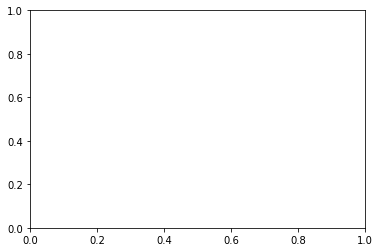

In [109]:
x = vif['variables']
y = vif['VIF']
vif = str(vif['variables'])
plt.scatter(x,y)
plt.xlim(min(x)-1,max(x)+1)
plt.ylim(min(y)-1,max(y)+1)

In [91]:
import matplotlib.pyplot as plt

In [105]:
vif.head()

,variables,VIF
0,fpsb_auction,7.409896
1,reserve_price,1.161375
2,municipality,6.868839
3,trend,inf
4,trend_treat,8.729106
